In [13]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import re
import multiprocessing
from collections import Counter
import itertools
import pickle
from IPython.display import display as disp
from IPython.display import Markdown, display_markdown

import numpy as np
# import bottleneck as bn
import pandas as pd
import networkx as nx
# import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
%matplotlib inline
sns.set_palette(colorcycle)
mpl.rcParams['figure.max_open_warning'] = 65
mpl.rcParams['figure.figsize'] = [12, 7]

# import warnings
# warnings.simplefilter("ignore", category=DeprecationWarning)
# warnings.simplefilter("ignore", category=mpl.cbook.mplDeprecation)
# warnings.simplefilter("ignore", category=UserWarning)


from speclib import misc, loaders, graph, plotting

pd.set_option('display.max_rows', 55)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
np.set_printoptions(linewidth=145)

# import pixiedust

List pickles

In [5]:
! /lscr_paper/allan/bin_allan/exa -l --header *.pkl

Permissions Size User   Date Modified Name
.rw-rw-r--   21k bzg778 26 Jul  1:51  usermove_statechange.pkl
.rw-rw-r--  399M bzg778 13 Aug  5:26  userMovement_adaboost_coarse.pkl
.rw-rw-r--  357M bzg778 21 Aug 13:57  userMovement_cv_GradientBoostingClassifier.pkl
.rw-rw-r--  356M bzg778 31 Jul 22:35  userMovement_cv_subgrid_search.pkl
.rw-rw-r--   52M bzg778  3 Oct 19:01  userMovement_rf_3_features.pkl
.rw-rw-r--   52M bzg778  5 Oct 16:46  userMovement_rf_3_features_fine.pkl
.rw-rw-r--  461M bzg778 31 Jul 22:09  userMovement_rf_coarse.pkl
.rw-rw-r--  667M bzg778  1 Aug 14:54  userMovement_rf_finer.pkl
.rw-rw-r--  531M bzg778 10 Oct 10:20  userMovement_rf_smote-randomforestclassifier_oversampled.pkl
.rw-rw-r--  356M bzg778 31 Jul 15:17  userMovement_sgd_std_final_coarse.pkl


In [6]:
pickle_lst = !ls *pkl

In [7]:
def load_pickle(pkl):
    with open(pkl, 'br') as fid:
        data= pickle.load(fid)
    return data

In [18]:
def present_model(gs, filename, ax=None, lb=None, alpha=1):
    mkd = [f"## {filename}\n"]
    mkd.append("#### Model steps\n")
    try:
        est = gs.best_estimator_.named_steps
    except AttributeError:
        est = gs.best_estimator_
    mkd.append('\n'.join(['\t' + ln for ln in repr(est).splitlines()]) + '\n\n') 
    mkd.append("#### AUC score")
    mkd.append(f"* Test score, best: {gs.best_score_}")
    try:
        mkd.append(f"* Validation score: {gs.validation_auc_score}")
        if ax is not None:
            # roc_label = filename.replace(".pkl", "").replace("userMovement", "").replace("cv_", "").strip('_')
            # roc_label = roc_label.title()[0] + roc_label[1:]
            plotting.plotROC(gs.y_va, gs.yhat, ax=ax, label=lb + ", AUC: {:.3f}".format(gs.validation_auc_score),
                             auc_do=lambda x: None, xy_guide=True, alpha=alpha)
    except AttributeError:
        mkd.append(f"* Validation score: Missing!")
    
    mkd_str = '\n'.join(mkd)
    display_markdown(mkd_str, raw=True)


In [19]:
name_labels = {"userMovement_cv_subgrid_search.pkl": "PCA n=28 & SGD balanced LR L2 regularized",
               "userMovement_sgd_std_final_coarse.pkl": "PCA n=27 & SGD unbalanced LR elesticnet",
               # "userMovement_adaboost_coarse.pkl": "Adaboost tree",
               "userMovement_cv_GradientBoostingClassifier.pkl": "Gradient Boosted tree",
               # "userMovement_rf_coarse.pkl": "Random Forest, coarse search",
               # "userMovement_rf_finer.pkl": "Random Forest, fine search",
               "userMovement_rf_finer.pkl": "Random Forest",
               # "userMovement_rf_3_features.pkl": "Random Forest, B7, B3 & G7, coarse",
               # "userMovement_rf_3_features_fine.pkl": "Random Forest, B7, B3 & G7, fine"} 
               "userMovement_rf_3_features_fine.pkl": "Random Forest, B7, B3 & G7"} 

## userMovement_cv_subgrid_search.pkl

#### Model steps

	{'pca': PCA(copy=True, iterated_power='auto', n_components=28, random_state=None,
	  svd_solver='auto', tol=0.0, whiten=False), 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'sgd': SGDClassifier(alpha=0.7196856730011519, average=False,
	       class_weight='balanced', epsilon=0.1, eta0=0.0, fit_intercept=True,
	       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
	       n_iter=None, n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
	       shuffle=True, tol=None, verbose=0, warm_start=False)}


#### AUC score
* Test score, best: 0.8509705960241408
* Validation score: 0.8518750390426447

## userMovement_sgd_std_final_coarse.pkl

#### Model steps

	{'pca': PCA(copy=True, iterated_power='auto', n_components=27, random_state=None,
	  svd_solver='auto', tol=0.0, whiten=False), 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'sgd': SGDClassifier(alpha=1.0, average=False, class_weight='balanced', epsilon=0.1,
	       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
	       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
	       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
	       shuffle=True, tol=None, verbose=0, warm_start=False)}


#### AUC score
* Test score, best: 0.8510681121381051
* Validation score: 0.851849571922662

## userMovement_cv_GradientBoostingClassifier.pkl

#### Model steps

	GradientBoostingClassifier(criterion='friedman_mse', init=None,
	              learning_rate=0.5, loss='deviance', max_depth=5,
	              max_features=None, max_leaf_nodes=None,
	              min_impurity_decrease=0.0, min_impurity_split=None,
	              min_samples_leaf=1, min_samples_split=2,
	              min_weight_fraction_leaf=0.0, n_estimators=156, presort=True,
	              random_state=None, subsample=1.0, verbose=0,
	              warm_start=False)


#### AUC score
* Test score, best: 0.8584678684923261
* Validation score: 0.8590484332634439

## userMovement_rf_finer.pkl

#### Model steps

	{'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'rf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
	            max_depth=17, max_features='auto', max_leaf_nodes=None,
	            min_impurity_decrease=0.0, min_impurity_split=None,
	            min_samples_leaf=1, min_samples_split=2,
	            min_weight_fraction_leaf=0.0, n_estimators=97, n_jobs=1,
	            oob_score=False, random_state=None, verbose=0,
	            warm_start=False)}


#### AUC score
* Test score, best: 0.8589099565292093
* Validation score: 0.8582778421410656

## userMovement_rf_3_features_fine.pkl

#### Model steps

	{'rf': RandomForestClassifier(bootstrap=True, class_weight='balanced',
	            criterion='entropy', max_depth=3, max_features='auto',
	            max_leaf_nodes=None, min_impurity_decrease=0.0,
	            min_impurity_split=None, min_samples_leaf=1,
	            min_samples_split=2, min_weight_fraction_leaf=0.0,
	            n_estimators=3, n_jobs=1, oob_score=False, random_state=None,
	            verbose=0, warm_start=False)}


#### AUC score
* Test score, best: 0.8082054936709949
* Validation score: 0.8079359453201033

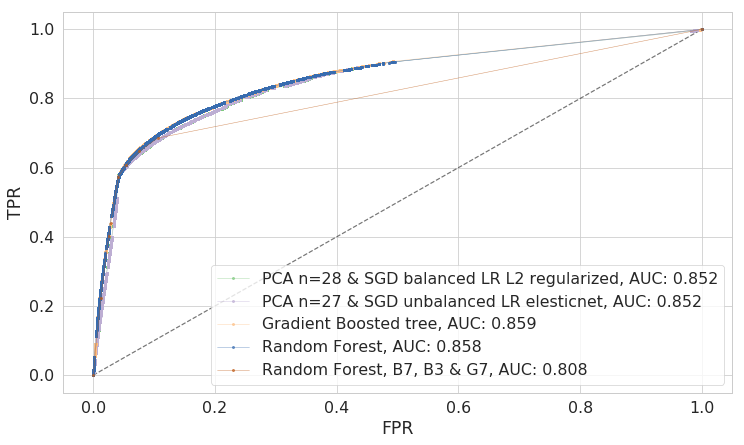

In [22]:
fig, ax = plt.subplots()
for pn, lb in name_labels.items():
    p = load_pickle(pn)
    present_model(p, pn, ax=ax, lb=lb, alpha=0.65)
ax.legend(loc="lower right") 
fig.savefig("figs/usermovement_roc_curve_collection.pdf")
fig.savefig("figs/usermovement_roc_curve_collection.png", dpi=400)